In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import gc
import time
import shutil
import random
import warnings
import typing as tp
from pathlib import Path
from contextlib import contextmanager

from tqdm import tqdm
import yaml
from joblib import delayed, Parallel

import cv2
import librosa
import audioread
import soundfile as sf

import numpy as np
import pandas as pd

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import resnest.torch as resnest_torch

import pytorch_pfn_extras as ppe
from pytorch_pfn_extras.training import extensions as ppe_extensions

from dataset import SpectrogramDataset

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
#   torch.backends.cudnn.deterministic = True  # type: ignore
#   torch.backends.cudnn.benchmark = True  # type: ignore


@contextmanager
def timer(name: str) -> None:
    """Timer Util"""
    t0 = time.time()
    print("[{}] start".format(name))
    yield
    print("[{}] done in {:.0f} s".format(name, time.time() - t0))

ROOT = Path.cwd()
INPUT_ROOT = ROOT / "../machine_sound"#"data" / "wav_data"

def get_loaders_for_training(
    args_dataset: tp.Dict, args_loader: tp.Dict,
    train_file_list: tp.List[str], val_file_list: tp.List[str]
):
    # # make dataset
    train_dataset = SpectrogramDataset(train_file_list, **args_dataset)
    val_dataset = SpectrogramDataset(val_file_list, **args_dataset)
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    val_loader = data.DataLoader(val_dataset, **args_loader["val"])

    return train_loader, val_loader, train_dataset, val_dataset

def get_model(args: tp.Dict):
    model =getattr(resnest_torch, args["name"])(pretrained=args["params"]["pretrained"])
    del model.fc
    #print(model)
    # # use the same head as the baseline notebook.
    model.fc = nn.Sequential(
        nn.Linear(2048, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, 1024), nn.ReLU(), nn.Dropout(p=0.2),
        nn.Linear(1024, args["params"]["n_classes"]))

    return model



def eval_for_batch(
    args, model, device,
    data, target, loss_func, eval_func_dict={}
):
    """
    Run evaliation for valid

    This function is applied to each batch of val loader.
    """
    model.eval()
    data, target = data.to(device), target.to(device)
    output = model(data)
    # Final result will be average of averages of the same size
    target = target.type_as(output)
    val_loss = loss_func(output, target).item()
    ppe.reporting.report({'val/loss': val_loss})

    for eval_name, eval_func in eval_func_dict.items():
        eval_value = eval_func(output, target).item()
        ppe.reporting.report({"val/{}".format(eval_aame): eval_value})



# 1. Parse dataset and make train/ val folds

tmp_list = []
for decibel_value in INPUT_ROOT.iterdir():
    if decibel_value.is_file():
        continue
    for machine in decibel_value.iterdir():
        if machine.is_file():
            continue
        machine_type = machine.stem
        print(f"Reading files in {machine_type} machine type")
        for id in machine.iterdir():
            if id.is_file():
                continue
            id_type = id.stem
            print(f"Reading files in {id_type}")
            for operation in id.iterdir():
                if operation.is_file():
                    continue
                operation_type = operation.stem
                assert operation_type in ["normal", "abnormal"], "Expected normal or abnormal"
                for wav_f in operation.iterdir():
                    if wav_f.is_file() and wav_f.suffix == ".wav":
                        tmp_list.append( [machine_type, id_type, operation_type,
                                          wav_f.name, wav_f.as_posix()])

train_all = pd.DataFrame(
    tmp_list, columns=["machine_type", "id_type", "operation_type",
                        "wav_filename", "wav_file_path"])

print(train_all.sample(n=5, random_state=1))
print('All df shape ', train_all.shape)

train_df, test_df = train_test_split(train_all, test_size=0.15, random_state=1234)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=1234)

print('Train df shape ', train_df.shape)
print('Test df shape ', val_df.shape)

#TODO: Here we can select to use only normal or abnormal data for training

train_file_list = train_df[["wav_file_path", "machine_type"]].values.tolist()
val_file_list = val_df[["wav_file_path", "machine_type"]].values.tolist()
test_file_list = test_df[["wav_file_path", "machine_type"]].values.tolist()

print("train: {}, val: {}, test: {}".format(len(train_file_list), len(val_file_list), len(test_file_list)))

with open('test_config_val.yaml') as settings_str:
    settings = yaml.safe_load(settings_str)

for k, v in settings.items():
    print("[{}]".format(k))
    print(v)

set_seed(settings["globals"]["seed"])
device = torch.device(settings["globals"]["device"])
output_dir = Path(settings["globals"]["output_dir"])

# # # get loader
_, test_loader, _, test_dataset = get_loaders_for_training(
    settings["dataset"]["params"], settings["loader"], train_file_list, test_file_list)

train_loader, val_loader, train_dataset, val_dataset = get_loaders_for_training(
    settings["dataset"]["params"], settings["loader"], train_file_list, val_file_list)

# # # get model
model = get_model(settings["model"])
model = model.to(device)

Reading files in pump machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in .ipynb_checkpoints machine type
Reading files in abnormal machine type
Reading files in .ipynb_checkpoints
Reading files in normal machine type
Reading files in slider machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in slider machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in pump machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in pump machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in fan machine type
Reading files in id_04
Reading files in id_00
Reading files in id_06
Reading files in id_02
Reading files in fan machine type
Reading files in id_04
Reading files in 

In [2]:
# Load weights
import glob
from collections import defaultdict
load_path = ''
weight_files = glob.glob("./training_output2/*.pth")#"#preprocess*")
weight_files.sort()

curr = weight_files[0]
for ctr, k in enumerate(weight_files):
    print(ctr, "\t", weight_files[ctr])
    curr = k 
    
indx = int(input("please enter your selection"))
load_path = weight_files[indx]

model.load_state_dict(torch.load(load_path))
model.eval()

0 	 ./training_output2/snapshot_epoch_1.pth
1 	 ./training_output2/snapshot_epoch_15.pth
2 	 ./training_output2/snapshot_epoch_2.pth
3 	 ./training_output2/snapshot_epoch_30.pth
4 	 ./training_output2/snapshot_epoch_31.pth
5 	 ./training_output2/snapshot_epoch_32.pth
6 	 ./training_output2/snapshot_epoch_4.pth
7 	 ./training_output2/snapshot_epoch_5.pth
8 	 ./training_output2/snapshot_epoch_6.pth
9 	 ./training_output2/snapshot_epoch_7.pth
please enter your selection5


ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): SplAtConv2d(
        (conv): Conv2d

In [3]:
# Results on validation data
# from tqdm import tqdm
# with torch.no_grad():
#     val_len = len(val_df)
#     val_batch_size = settings["loader"]["val"]["batch_size"]
#     val_steps_per_epoch = int(val_len / val_batch_size)

#     val_iter = iter(val_loader)
#     preds = []
#     gts = []
#     for k in tqdm(range(val_steps_per_epoch)):
#         x, y = next(val_iter)
#         data, target = x.to('cuda'), y.to('cuda')
#         y_pred = model(data)
#         preds.append(y_pred.cpu().numpy())
#         gts.append(y.cpu().numpy())

#         print(k/val_steps_per_epoch, end="\r", flush=True)
#         del x, y , data, target, y_pred
       
# Results on test data
from tqdm import tqdm
with torch.no_grad():
    test_len = len(test_df)
    test_batch_size = settings["loader"]["val"]["batch_size"]
    test_steps_per_epoch = int(test_len / test_batch_size)

    test_iter = iter(test_loader)
    preds = []
    gts = []
    for k in tqdm(range(test_steps_per_epoch)):
        x, y = next(test_iter)
        data, target = x.to('cuda'), y.to('cuda')
        y_pred = model(data)
        preds.append(y_pred.cpu().numpy())
        gts.append(y.cpu().numpy())

        #print(k/test_steps_per_epoch, end="\r", flush=True)
        del x, y , data, target, y_pred
    

  0%|          | 0/337 [00:00<?, ?it/s]/home/ubuntu/anudeep/miniconda3/envs/pytorch_machine/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 337/337 [10:14<00:00,  1.82s/it]


In [4]:
preds = np.array(preds)
gts = np.array(gts)
preds = np.concatenate(preds, axis=0)
gts = np.concatenate(gts, axis=0)
_preds = np.argmax(preds, axis=-1)
_gts = np.argmax(gts, axis=-1)
_preds.shape, _gts.shape

((8088,), (8088,))

In [5]:
import sklearn
target_names = ["pump", "valve", "slider", "fan"]
print(sklearn.metrics.classification_report(_gts, _preds, target_names=target_names))

              precision    recall  f1-score   support

        pump       1.00      0.99      0.99      1879
       valve       1.00      1.00      1.00      1922
      slider       1.00      1.00      1.00      1845
         fan       1.00      1.00      1.00      2442

    accuracy                           1.00      8088
   macro avg       1.00      1.00      1.00      8088
weighted avg       1.00      1.00      1.00      8088



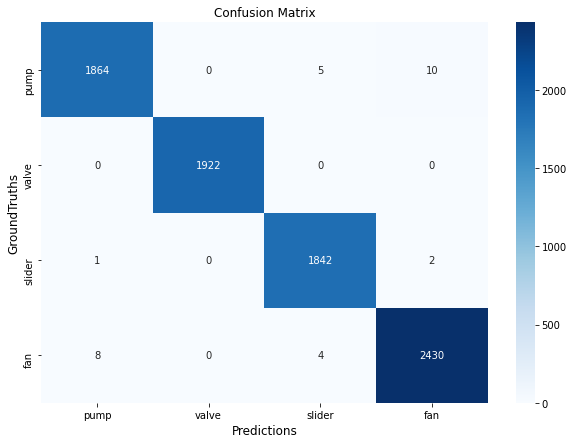

In [6]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
array = sklearn.metrics.confusion_matrix(_gts, _preds)
df_cm = pd.DataFrame(array, index = [i for i in target_names],
                  columns = [i for i in target_names])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predictions', fontsize=12)
plt.ylabel('GroundTruths', fontsize=12)
plt.title('Confusion Matrix', fontsize=12)

plt.show()